In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
ravexmatch = pd.read_csv('/data/jls/GaiaDR2/spectro/RAVE_xmatch.csv')
rave_dr5 = pd.read_hdf('/data/jls/GaiaDR2/spectro/RAVE_input.hdf5')

rave_dr5_x = rave_dr5.merge(ravexmatch,left_on='raveid',right_on='original_ext_source_id',how='inner',suffixes=['','G'])
rave_dr5_x_all = rave_dr5.merge(ravexmatch,left_on='raveid',right_on='original_ext_source_id',how='left',suffixes=['','G'])

extra = rave_dr5_x[rave_dr5_x.source_id!=rave_dr5_x.source_idG].reset_index(drop=True)
print len(extra)

columns = ['parallax', 'parallax_error',
               'pmra', 'pmdec',
               'pmra_error', 'pmdec_error',
               'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
               'source_id','G','GBP','GRP','eG','eGRP','eGBP',
               'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper']
extra = extra.drop(columns, axis=1)

extra['source_id']=extra['source_idG']
extra = extra.drop(['source_idG'],axis=1)

1971


In [3]:
len(ravexmatch), len(rave_dr5)

(450587, 457555)

In [4]:
nomatch = rave_dr5_x_all[rave_dr5_x_all.original_ext_source_id!=rave_dr5_x_all.original_ext_source_id].reset_index(drop=True)

In [86]:
import sqlutil
from login import wsdbpassword
def grab_background(ra, dec,epoch):
    return pd.DataFrame.from_dict(
                sqlutil.get(
                    'select g.*, q3c_dist_pm(g.ra, g.dec, g.pmra, g.pmdec, g.ref_epoch, %0.9f, %0.9f, g.ref_epoch-%0.5f) as dist '
                    'from gaia_dr2.gaia_source as g where '
                    'q3c_radial_query(g.ra, g.dec, %0.9f, %0.9f, 150./3600.) and '
                    'q3c_join_pm(g.ra, g.dec, g.pmra, g.pmdec, g.ref_epoch, %0.9f, %0.9f, g.ref_epoch-%0.5f,%0.5f, 20/3600.)'
                    'order by q3c_dist_pm(g.ra, g.dec, g.pmra, g.pmdec, g.ref_epoch, %0.9f, %0.9f, g.ref_epoch-%0.5f) limit 1'\
                        %(ra, dec, epoch, ra,dec,ra,dec,epoch, epoch,ra,dec,epoch),
                               host='cappc127',
                              user='jason_sanders',
                              password=wsdbpassword,
                              preamb='set enable_seqscan to off; ' +
                              'set enable_mergejoin to off; ' +
                              'set enable_hashjoin to off;',
                              asDict=True,
                              strLength=35))

(12.1673, 10.982999999999999, 10.587, 0.018947, 0.3309469448024524)

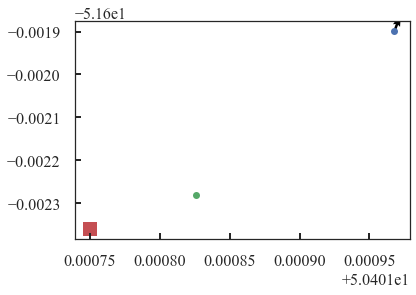

In [34]:
xx = 5000
g = grab_background(nomatch['ra'][xx],nomatch['dec'][xx], 15.)
plt.plot(g['ra'],g['dec'],'.')
plt.quiver(g['ra'],g['dec'],g['pmra'],g['pmdec'])
plt.plot(g['ra']-g['pmra']*15/3600000.,g['dec']-g['pmdec']*15/3600000.,'.')
plt.plot(nomatch['ra'][xx],nomatch['dec'][xx],'s',zorder=-1)
g['phot_g_mean_mag'][0], nomatch['J'][xx], nomatch['K'][xx], g['ebv'][0], g['dist'][0]*3600.

In [29]:
cgextra = crossmatch_gaia(extra,no_proper_motion=False)


        select tt.* from mytable as m left join lateral
        (select *, q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00) as dist from gaia_dr2.gaia_source as s where q3c_join(m.ra,m.dec,s.ra,s.dec,0.01388889) and q3c_join_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00,20.,0.00138889) order by q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00)  asc limit 1)
        as tt on  true  order by xid 


In [33]:
PP = rave_dr5_x[rave_dr5_x.source_id!=rave_dr5_x.source_idG]

In [32]:
len(cgextra)

1971

In [5]:
import sys
sys.path.append('../')
from cross_match import *

In [12]:
cg = crossmatch_gaia(nomatch,no_proper_motion=False)


        select tt.* from mytable as m left join lateral
        (select *, q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00) as dist from gaia_dr2.gaia_source as s where q3c_join(m.ra,m.dec,s.ra,s.dec,0.01388889) and q3c_join_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00,20.,0.00138889) order by q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00)  asc limit 1)
        as tt on  true  order by xid 


In [13]:
np.count_nonzero(cg.source_id>0.)

5787

In [12]:
g = crossmatch_gaia_spectro_id(extra)


        select tt.* from gaia_dr2.gaia_source as tt, mytable as m where tt.source_id=m.source_id


In [27]:
g.to_hdf('/data/jls/GaiaDR2/spectro/RAVE_input_extra.hdf5','data')

/data/jls/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['rave_obs_id', 'raveid', 'zeropointflag', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'RAVE_OBS_ID_x', 'RAVE_OBS_ID_y', 'mag_use', 'original_ext_source_id']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [36]:
import sys
sys.path.append('../')
from cross_match import crossmatch_gaia


        select tt.* from mytable as m left join lateral
        (select *, q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00) as dist from gaia_dr2.gaia_source as s where q3c_join_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00,20.,0.00138889) order by q3c_dist_pm(s.ra,s.dec,s.pmra,s.pmdec,s.ref_epoch,m.ra,m.dec,2000.00)  asc limit 1)
        as tt on  true  order by xid 


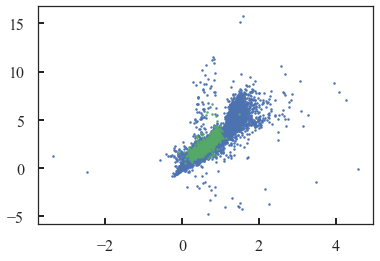

In [24]:
plt.plot((rave_dr5_x.J-rave_dr5_x.K)[rave_dr5_x.source_id==rave_dr5_x.source_idG],
         (rave_dr5_x.G-rave_dr5_x.H)[rave_dr5_x.source_id==rave_dr5_x.source_idG],'.',ms=5)
plt.plot(g.J-g.K,g.G-g.H,'.',ms=5)

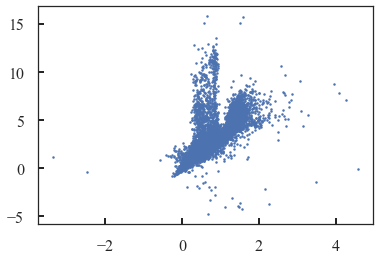

In [23]:
plt.plot((rave_dr5.J-rave_dr5.K),
         (rave_dr5.G-rave_dr5.H),'.',ms=5)

In [29]:
ravexmatch = pd.read_csv('/data/jls/GaiaDR2/spectro/RAVE_xmatch.csv')
rave_dr5 = pd.read_hdf('/data/jls/GaiaDR2/spectro/RAVEON_input.hdf5')

rave_dr5_x = rave_dr5.merge(ravexmatch,left_on='raveid',right_on='original_ext_source_id',how='inner',suffixes=['','G'])

extra = rave_dr5_x[rave_dr5_x.source_id!=rave_dr5_x.source_idG].reset_index(drop=True)
print len(extra)

columns = ['parallax', 'parallax_error',
               'pmra', 'pmdec',
               'pmra_error', 'pmdec_error',
               'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
               'source_id','G','GBP','GRP','eG','eGRP','eGBP',
               'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper']
extra = extra.drop(columns, axis=1)

extra['source_id']=extra['source_idG']
extra = extra.drop(['source_idG'],axis=1)

1971


In [30]:
g = crossmatch_gaia_spectro_id(extra)


        select tt.* from gaia_dr2.gaia_source as tt, mytable as m where tt.source_id=m.source_id


In [31]:
g.to_hdf('/data/jls/GaiaDR2/spectro/RAVEON_input_extra.hdf5','data')

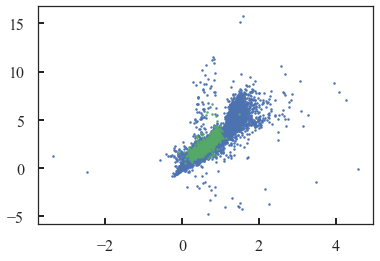

In [32]:
plt.plot((rave_dr5_x.J-rave_dr5_x.K)[rave_dr5_x.source_id==rave_dr5_x.source_idG],
         (rave_dr5_x.G-rave_dr5_x.H)[rave_dr5_x.source_id==rave_dr5_x.source_idG],'.',ms=5)
plt.plot(g.J-g.K,g.G-g.H,'.',ms=5)

[]

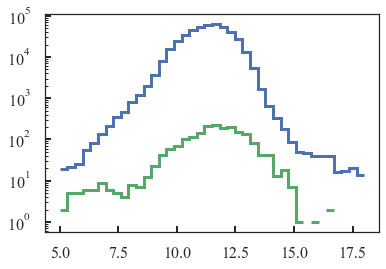

In [37]:
plt.hist(rave_dr5.G,range=[5.,18.],histtype='step',lw=3,bins=40);
plt.hist(g.G,range=[5.,18.],histtype='step',lw=3,bins=40);
plt.semilogy()

In [38]:
len(extra)

1971

In [39]:
len(rave_dr5_x)

450587

In [104]:
rave_dr5_pm = pd.read_hdf('/data/jls/GaiaDR2/spectro/RAVE_input_pm.hdf5')

In [105]:
len(rave_dr5_pm)

0

In [43]:
rave_dr5_pm.loc[rave_dr5_pm.source_id<0,'source_id']=np.nan
rave_dr5.loc[rave_dr5.source_id<0,'source_id']=np.nan

In [41]:
np.count_nonzero(rave_dr5.source_id>0)

455641

In [103]:
len(rave_dr5_pm.di

457555

In [47]:
rave_dr5_pm.columns

Index([u'rave_obs_id', u'raveid', u'ra', u'dec', u'hrv', u'e_hrv',
       u'stddev_hrv', u'mad_hrv', u'correlationcoeff', u'peakheight',
       u'peakwidth', u'correctionrv', u'skyrv', u'eskyrv',
       u'skycorrelationcoeff', u'vrot_sparv', u'zeropointflag', u'c1', u'c2',
       u'c3', u'c4', u'c5', u'c6', u'c7', u'c8', u'c9', u'c10', u'c11', u'c12',
       u'c13', u'c14', u'c15', u'c16', u'c17', u'c18', u'c19', u'c20', u'teff',
       u'logg', u'fe_h', u'o_h', u'mg_h', u'al_h', u'si_h', u'ca_h', u'ni_h',
       u'e_teff', u'e_logg', u'e_fe_h', u'e_o_h', u'e_mg_h', u'e_al_h',
       u'e_si_h', u'e_ca_h', u'e_ni_h', u'snr', u'r_chi_sq', u'qc',
       u'RAVE_OBS_ID_x', u'Teff_N_K', u'eTeff_K', u'logg_N_K', u'elogg_K',
       u'Met_N_K', u'eMet_K', u'J', u'eJ', u'H', u'eH', u'K', u'eK',
       u'RAVE_OBS_ID_y', u'rho_Tg', u'rho_TZ', u'rho_gZ', u'mag_use', u'mass',
       u'mass_error', u'source_id', u'parallax', u'parallax_error', u'pmra',
       u'pmra_error', u'pmdec', u'pmdec_error', 

In [51]:
np.count_nonzero(rave_dr5.source_id[(rave_dr5.source_id!=rave_dr5_pm.source_id)&(rave_dr5_pm.source_id>0.)]>0)

1015

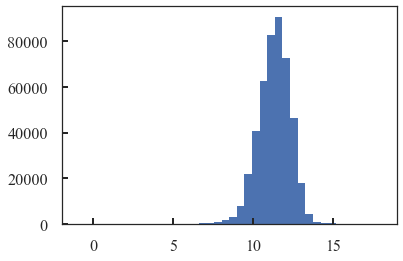

In [55]:
plt.hist(rave_dr5['G'],range=[-1.,18.],bins=40);

In [59]:
rave_dr5_pm_x = rave_dr5_pm.merge(ravexmatch,left_on='raveid',right_on='original_ext_source_id',how='inner',suffixes=['','G'])
rave_dr5_pm_x_all = rave_dr5_pm.merge(ravexmatch,left_on='raveid',right_on='original_ext_source_id',how='left',suffixes=['','G'])

extra_pm = rave_dr5_pm_x[rave_dr5_pm_x.source_id!=rave_dr5_pm_x.source_idG].reset_index(drop=True)
print len(extra_pm)

240


In [60]:
nomatch = rave_dr5_pm_x_all[rave_dr5_pm_x_all.original_ext_source_id!=rave_dr5_pm_x_all.original_ext_source_id].reset_index(drop=True)

(10.8657, 9.846, 9.482999999999999, 0.040692, 0.4810615334158032)

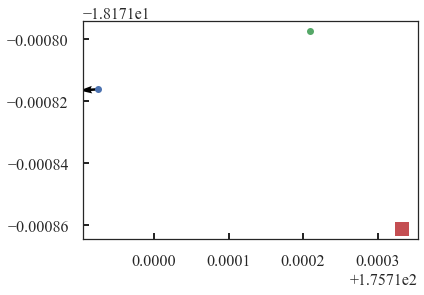

In [65]:
xx = 4000
g = grab_background(nomatch['ra'][xx],nomatch['dec'][xx], 15.)
plt.plot(g['ra'],g['dec'],'.')
plt.quiver(g['ra'],g['dec'],g['pmra'],g['pmdec'])
plt.plot(g['ra']-g['pmra']*15/3600000.,g['dec']-g['pmdec']*15/3600000.,'.')
plt.plot(nomatch['ra'][xx],nomatch['dec'][xx],'s',zorder=-1)
g['phot_g_mean_mag'][0], nomatch['J'][xx], nomatch['K'][xx], g['ebv'][0], g['dist'][0]*3600.

In [67]:
np.count_nonzero(rave_dr5_pm.source_id!=rave_dr5_pm.source_id)

1207

In [107]:
gg = pd.read_hdf('/data/jls/GaiaDR2/spectro/%s_input_pm.hdf5'%'GES')

In [78]:
len(gg)

0

In [109]:
gg2 = pd.read_hdf('/data/jls/GaiaDR2/spectro/%s_input.hdf5'%'GES')

In [110]:
gg2[gg2.source_id<0]

,CNAME,GES_FLD,OBJECT,GES_TYPE,SETUP,ra,dec,hrv,e_hrv,teff,...,pmra_pmdec_corr,G,GBP,GRP,a_g_val,a_g_percentile_lower,a_g_percentile_upper,eG,eGRP,eGBP
1112,11115400-7619311,Cha_I,11115400-7619311,GE_CL,HR15N,167.97500,-76.32531,16.25000,0.240000,3785.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649,19225696+0130464,Corot,100515333,GE_SD_CR,NaN,290.73733,1.51289,5.20000,0.106053,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5496,08395401-0757136,GES_MW_08_09,U_2_b_144_67,GE_MW,U580,129.97504,-7.95378,54.06010,0.565685,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8447,17574777+0444034,GJ699,GJ699,GE_SD_BM,U580,269.44904,4.73428,-109.99000,0.565685,3417.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824,08431303-5329082,IC2391,2MASS08431303-5329082,GE_CL,HR15N,130.80429,-53.48561,22.58880,0.292216,3400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9572,12191274-3655409,GES_MW_12_13,G_2_r_186_92,GE_MW,NaN,184.80308,-36.92803,-8.47425,0.158616,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11158,15423833-4416383,GES_MW_15_16,U_2_b_30_213,GE_MW,U580,235.65971,-44.27731,-29.41080,0.565685,6065.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11854,07592938-6040026,NGC2516,NGC2516_11142,GE_CL,HR15N,119.87242,-60.66739,40.31490,0.273756,3663.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12065,07571418-6040524,NGC2516,NGC2516_6029,GE_CL,HR15N,119.30908,-60.68122,30.17520,0.241467,5946.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12417,08093671-4911383,NGC2547,T08093671-4911383|T08093671-4911383|T08093671-...,GE_CL,NaN,122.40296,-49.19397,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
g = grab_background(129.97504,-7.95378,15.)

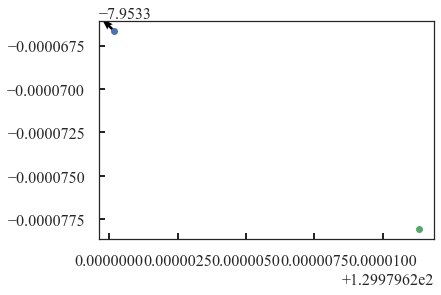

In [91]:
g = grab_background(129.97504,-7.95378,15.)
plt.plot(g['ra'],g['dec'],'.')
plt.quiver(g['ra'],g['dec'],g['pmra'],g['pmdec'])
plt.plot(g['ra']-g['pmra']*15/3600000.,g['dec']-g['pmdec']*15/3600000.,'.')

In [93]:
(g['ra']-129.97504)*3600.

0    16.48866
Name: ra, dtype: float64

In [96]:
g['phot_g_mean_mag']

0    16.169201
Name: phot_g_mean_mag, dtype: float32

In [102]:
gg2.iloc[5496]['J']

13.38